In [18]:
import nrrd
import numpy as np
from utils import imshow

# readdata, header = nrrd.read('../data/1241031155/9.40CHESTSegmentation.seg.nrrd')
labeldata, header = nrrd.read('../data/1241031155/9.40CHESTSegmentation-label.nrrd')
image, header2 = nrrd.read('../data/1241031155/9.40CHESTABDPELVIS.nrrd')

(512, 512, 265)
(512, 512, 265)


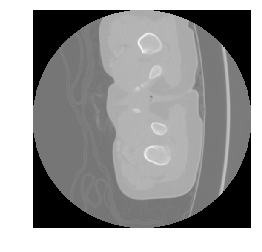

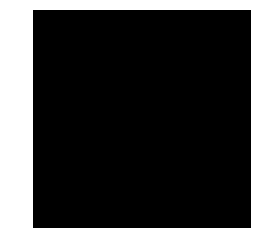

In [19]:
print(image.shape)
print(labeldata.shape)
imshow(image)
imshow(labeldata)

(265, 512, 512, 1)
(265, 512, 512, 1)


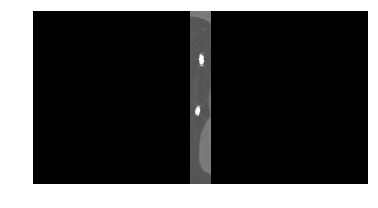

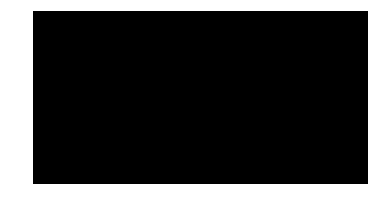

In [20]:

image = np.swapaxes(image, 0, 2)
labeldata = np.swapaxes(labeldata, 0, 2)

#add the fourth dimension (modality) which is just 1
image = np.expand_dims(image, axis=3)
labeldata = np.expand_dims(labeldata, axis=3)

print(image.shape)
print(labeldata.shape)
imshow(image)
imshow(labeldata)

(1, 512, 512, 1)
(1, 512, 512, 1)


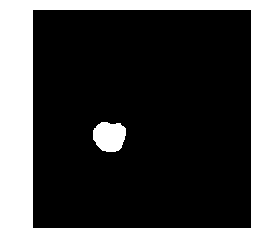

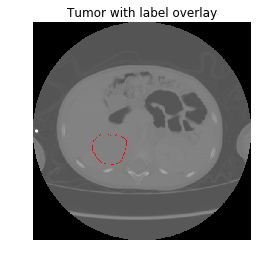

In [21]:
lbl = labeldata[[132],...] #takes one slice of the 265
img = image[[132],...] #takes one slice of the 265

print(img.shape)
print(lbl.shape)

# imshow(img)
imshow(lbl)
imshow(dat=img, lbl=lbl, title='Tumor with label overlay')

In [22]:
import tensorflow as tf


print(type(img))
print(img.shape)


X = tf.placeholder(tf.float32, [None, 512, 512, 1])

conv = tf.layers.conv2d(X, filters=8, kernel_size=(3, 3), padding='same')
relu = tf.nn.relu(conv)
pool = tf.layers.max_pooling2d(relu, pool_size=(2, 2), strides=(2, 2))

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

output = sess.run(pool, feed_dict={X: img})

print(output.shape)

<class 'numpy.ndarray'>
(1, 512, 512, 1)
(1, 256, 256, 8)


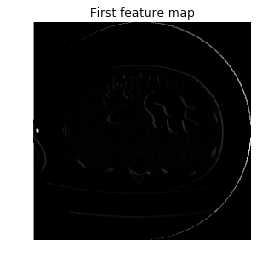

In [23]:
imshow(output[..., 0], title='First feature map')


In [24]:
sess.close()


In [25]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, 512, 512, 1], name='X')
y = tf.placeholder(tf.int32, shape=[None], name='y')
mode = tf.placeholder(tf.bool, name='mode')

In [26]:
import net

In [27]:
pred = net.create_classifier2(X, training=mode)
print(pred.shape)
print(pred)
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=pred)

(?, 2)
Tensor("Flatten/flatten/Reshape:0", shape=(?, 2), dtype=float32)


In [28]:
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)
print(lbl.shape)

(1, 512, 512, 1)


(1, 512, 512, 1)
(1, 512, 512, 1)
REAL (tumor, y/n?): y
PRED (tumor, y/n?): n
LOSS (lower value is better prediction): 3.542008


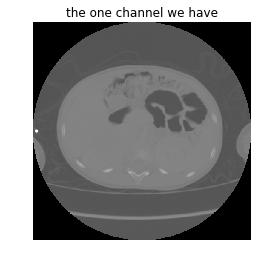

[1]


In [29]:
# dat, lbl = data.load(mode='train', n=1)
print(img.shape)
print(lbl.shape)
lbl = np.max(lbl > 0, axis=(1,2,3)).astype('int32')
sce, logits = sess.run([loss, pred], {X: img, y: lbl, mode: True})

print('REAL (tumor, y/n?): %s' % ('y' if lbl else 'n'))
print('PRED (tumor, y/n?): %s' % ('y' if logits[0, 1] > logits[0, 0] else 'n'))
print('LOSS (lower value is better prediction): %f' % sce)

imshow(img[..., 0], title='the one channel we have')
print(lbl)

In [30]:
sess.close()

In [20]:
# taken from: https://www.tensorflow.org/tutorials/estimators/cnn
print("new section")

new section


In [25]:
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])

  # Convolutional Layer #1
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer #1
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2 and Pooling Layer #2
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Dense Layer
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits Layer
  logits = tf.layers.dense(inputs=dropout, units=10)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [26]:
# main starts here

# Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)


Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [27]:
print(type(train_labels))
print(train_labels.shape)
print(train_labels[0])
print(type(train_labels[0]))
print(train_data.shape)

<class 'numpy.ndarray'>
(55000,)
7
<class 'numpy.int32'>
(55000, 784)


In [28]:
 
# labeldata, header = nrrd.read('../data/1241031155/9.40CHESTSegmentation-label.nrrd')
# image, header2 = nrrd.read('../data/1241031155/9.40CHESTABDPELVIS.nrrd')

In [29]:
# print(type(image))
# # image = image.astype(np.float32)
# # print(image)
# print(image.shape)
# print(type(image[0][0][0]))

In [30]:
# image = np.swapaxes(image, 0, 2)
# labeldata = np.swapaxes(labeldata, 0, 2)

# #add the fourth dimension (modality) which is just 1
# image = np.expand_dims(image, axis=3)
# labeldata = np.expand_dims(labeldata, axis=3)

# image = image.astype(np.float32)

# print(image.shape)
# print(labeldata.shape)

# print(np.linalg.matrix_rank(labeldata))

In [31]:
# image = np.swapaxes(image, 0, 2)
# lbl = np.swapaxes(readdata, 0, 2)
# train_data = image
# train_labels = labeldata

# print(type(train_data))
# print(train_data.shape)
# print(train_labels.shape)

neuro_classifier = tf.estimator.Estimator(
model_fn=cnn_model_fn, model_dir="/tmp/neuro_convnet_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/neuro_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x12dff04a8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [32]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [33]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)

In [34]:
neuro_classifier.train(
    input_fn=train_input_fn,
    steps=20000,
    hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/neuro_convnet_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.10475449 0.10739336 0.08697172 0.11719643 0.09409863 0.09937232
  0.11124659 0.10542862 0.09190496 0.08163287]
 [0.09379344 0.10018495 0.09695059 0.10940686 0.09134109 0.10803699
  0.10455203 0.10365588 0.10873575 0.08334241]
 [0.09544101 0.1059247  0.09943596 0.11067945 0.08865725 0.1133768
  0.10956175 0.11182186 0.0898028  0.07529846]
 [0.08963738 0.10263883 0.10018528 0.12092659 0.08969276 0.0991962
  0.11160384 0.10425915 0.10206813 0.07979181]
 [0.10792994 0.09139074 0.09955431 0.10350891 0.08639508 0.10245769
  0.11777545 0.09865011 0.10629645 0.08604131]
 [0.0994093  0.11468874 0.09017242 0.12083831 0.088182   0.11142433
  0.114

INFO:tensorflow:loss = 2.310978, step = 1
INFO:tensorflow:probabilities = [[0.09975426 0.10183663 0.09615703 0.10827167 0.08897909 0.11712459
  0.10845709 0.09398967 0.09416216 0.09126775]
 [0.09443614 0.0908284  0.08946813 0.10977618 0.09421208 0.10744087
  0.11720484 0.10671286 0.10225984 0.08766058]
 [0.09578708 0.10163172 0.09598395 0.10932563 0.08240445 0.10282041
  0.13111946 0.09712012 0.09022409 0.09358312]
 [0.09883319 0.09705848 0.10657138 0.10419339 0.09222478 0.10877635
  0.10177939 0.09657355 0.09605473 0.09793471]
 [0.09274149 0.10140097 0.09818672 0.11080017 0.09145552 0.10351457
  0.10411585 0.09646123 0.10440516 0.09691842]
 [0.09388098 0.10100167 0.10335139 0.10849396 0.08764204 0.11207907
  0.11222232 0.09715815 0.0945851  0.08958531]
 [0.09773581 0.09762173 0.09787036 0.10980378 0.08747033 0.10232069
  0.11594953 0.09968967 0.09549836 0.09603973]
 [0.09765401 0.09647374 0.09237845 0.11752521 0.09802694 0.10250093
  0.1121549  0.09824036 0.09483746 0.09020796]
 [0.09

INFO:tensorflow:global_step/sec: 4.65458
INFO:tensorflow:probabilities = [[0.10073365 0.09051383 0.099182   0.10034981 0.08906118 0.10856735
  0.11908731 0.10073761 0.09648655 0.09528075]
 [0.08940092 0.11077719 0.08782586 0.10389286 0.09858621 0.10655251
  0.1193369  0.09838996 0.10065211 0.08458549]
 [0.10142541 0.09966373 0.09970696 0.10165623 0.10055842 0.11204179
  0.11540626 0.0887892  0.09189492 0.08885704]
 [0.10103513 0.09989735 0.08921134 0.10090303 0.09096583 0.11204644
  0.10977484 0.09837255 0.09749933 0.10029414]
 [0.10086151 0.09138009 0.10371737 0.10752188 0.0908032  0.10314945
  0.10896578 0.103078   0.10099906 0.0895236 ]
 [0.10000469 0.09469659 0.09868839 0.11021511 0.09937312 0.10657737
  0.10517853 0.09220249 0.09738605 0.09567765]
 [0.10129274 0.09745264 0.09855588 0.10287258 0.09672055 0.09807941
  0.11405152 0.10577483 0.0878093  0.09739058]
 [0.09681864 0.09897709 0.09305144 0.10689767 0.09531137 0.11964575
  0.10267337 0.09658027 0.10069045 0.0893539 ]
 [0.097

INFO:tensorflow:loss = 2.2910416, step = 101 (21.484 sec)
INFO:tensorflow:probabilities = [[0.10473818 0.1014431  0.09490222 0.11071485 0.08118241 0.10213599
  0.10357071 0.10978088 0.10282837 0.08870327]
 [0.09938803 0.10175627 0.09995411 0.11479547 0.08437108 0.10981028
  0.10925215 0.09205087 0.09994847 0.08867326]
 [0.10535114 0.09350144 0.0937777  0.11983523 0.08519504 0.10175792
  0.10610126 0.10034977 0.10788884 0.08624166]
 [0.09574498 0.10856338 0.09725637 0.10423312 0.08806727 0.11041268
  0.10629141 0.09894317 0.10218932 0.08829822]
 [0.09973033 0.1010353  0.0903695  0.11601475 0.09566956 0.10469621
  0.10310252 0.09912514 0.09652963 0.09372712]
 [0.09887741 0.09653384 0.09305408 0.10912398 0.08905143 0.10925324
  0.1110018  0.10035978 0.09833588 0.09440857]
 [0.11038304 0.10235811 0.09451772 0.10228741 0.08528415 0.09419996
  0.11036237 0.09645523 0.10668843 0.09746358]
 [0.101928   0.09808617 0.09824044 0.10052975 0.09249232 0.09464517
  0.09802125 0.10172331 0.11306873 0.

INFO:tensorflow:global_step/sec: 4.92387
INFO:tensorflow:probabilities = [[0.1086768  0.08254031 0.09163778 0.10495276 0.09272333 0.1079676
  0.11414518 0.10096313 0.09693053 0.09946252]
 [0.09861074 0.10242528 0.08909905 0.10530882 0.08971233 0.10747695
  0.11329123 0.09957165 0.10324503 0.09125891]
 [0.09642706 0.10527229 0.10000528 0.10458123 0.09171597 0.10113138
  0.10449909 0.10552667 0.09760477 0.0932363 ]
 [0.10757273 0.09689053 0.08566935 0.10333186 0.09601636 0.1097016
  0.10893922 0.09721483 0.0992569  0.09540661]
 [0.09991685 0.09881874 0.08660939 0.10761824 0.09876908 0.10501193
  0.10954799 0.09835494 0.09949046 0.09586242]
 [0.09769975 0.09002644 0.09847606 0.10914905 0.08827478 0.10476251
  0.11510652 0.09986838 0.10501857 0.09161796]
 [0.10376147 0.09535009 0.09535864 0.10020326 0.09102242 0.10070793
  0.10297386 0.11026391 0.09311219 0.10724624]
 [0.09564212 0.1007319  0.10923436 0.1133968  0.09146425 0.09373081
  0.1001242  0.10366199 0.10461294 0.08740062]
 [0.10047

INFO:tensorflow:loss = 2.2838385, step = 201 (20.309 sec)
INFO:tensorflow:probabilities = [[0.09417566 0.10129968 0.09419071 0.10741545 0.09029404 0.11617068
  0.10849439 0.10502946 0.09143008 0.09149984]
 [0.09990879 0.09989455 0.09249382 0.10880197 0.08602497 0.10395933
  0.11541485 0.09582733 0.10146589 0.09620856]
 [0.10156289 0.10360288 0.09199322 0.11043847 0.09201694 0.10129651
  0.10866081 0.10147718 0.10373928 0.08521184]
 [0.10145526 0.10889822 0.0997774  0.10677742 0.08800641 0.1022622
  0.10205482 0.10009138 0.09558571 0.09509114]
 [0.10205607 0.0805066  0.08409249 0.12816922 0.09847677 0.10087623
  0.10727353 0.10386265 0.10419918 0.09048728]
 [0.10048104 0.11043059 0.0870138  0.11165305 0.0906079  0.10395538
  0.10933064 0.09259877 0.09778172 0.09614716]
 [0.10523239 0.09149583 0.09410889 0.11992506 0.09464438 0.08976562
  0.10939218 0.09807345 0.10139935 0.0959628 ]
 [0.10344054 0.10162034 0.09027629 0.12000614 0.08996861 0.10362415
  0.10202077 0.09521263 0.09897789 0.0

INFO:tensorflow:global_step/sec: 4.62777
INFO:tensorflow:probabilities = [[0.09767028 0.10898425 0.10077647 0.10159574 0.08460317 0.10822911
  0.10575493 0.09659045 0.10598628 0.08980924]
 [0.1068066  0.09182377 0.1011427  0.10109636 0.09519628 0.09916262
  0.10177579 0.09426593 0.10482598 0.10390402]
 [0.10524838 0.10063799 0.09528819 0.10901114 0.09513292 0.10234221
  0.10306323 0.10269134 0.09383857 0.092746  ]
 [0.09887849 0.10140886 0.09450329 0.11410721 0.08463267 0.10430479
  0.10712855 0.09842873 0.10601959 0.09058782]
 [0.1045122  0.1082276  0.10421563 0.09978689 0.09476798 0.09400736
  0.09942523 0.10088251 0.10137836 0.09279627]
 [0.11862931 0.09513658 0.10030793 0.09426481 0.07883573 0.09436028
  0.10912679 0.09383947 0.10530598 0.11019315]
 [0.10386153 0.10515468 0.10089692 0.10173529 0.09273813 0.0965437
  0.10592754 0.09269756 0.10416002 0.09628458]
 [0.09995846 0.09739156 0.096266   0.10557854 0.09243505 0.10560022
  0.1096101  0.09712885 0.10261708 0.09341414]
 [0.0979

INFO:tensorflow:loss = 2.27867, step = 301 (21.608 sec)
INFO:tensorflow:probabilities = [[0.09275427 0.11056229 0.10339938 0.10102645 0.09909306 0.0969738
  0.10237217 0.10420796 0.09766122 0.0919494 ]
 [0.09589375 0.09609095 0.09611339 0.11294432 0.10068913 0.10199659
  0.11292524 0.09670604 0.09400066 0.09263989]
 [0.10157155 0.09713599 0.09152307 0.10831086 0.08245844 0.10136966
  0.10202501 0.09737958 0.10986344 0.1083624 ]
 [0.10471136 0.10204338 0.09847555 0.10417624 0.08799493 0.10039485
  0.10503361 0.09760967 0.10049242 0.09906796]
 [0.0893814  0.10894989 0.10093216 0.10786558 0.09338554 0.104936
  0.10330831 0.09831912 0.10241902 0.09050291]
 [0.09969234 0.0996126  0.10746975 0.10785154 0.09013701 0.10428169
  0.10628881 0.09858233 0.09504364 0.09104022]
 [0.08732536 0.09716738 0.10696366 0.12247709 0.08822574 0.10699748
  0.11963548 0.07988665 0.1049186  0.08640252]
 [0.10031459 0.10578234 0.09936233 0.09474833 0.08965364 0.10290038
  0.11301144 0.09489205 0.10718609 0.09214

INFO:tensorflow:global_step/sec: 4.20788
INFO:tensorflow:probabilities = [[0.10654985 0.09167922 0.0980453  0.1002667  0.09462306 0.09245088
  0.10692547 0.09893209 0.10584445 0.10468298]
 [0.09821809 0.09963241 0.09671714 0.11431102 0.09276769 0.10430087
  0.09766956 0.10059956 0.09889407 0.09688956]
 [0.10001218 0.10058118 0.10239986 0.10055684 0.10032342 0.09182974
  0.11335906 0.09548763 0.10509344 0.09035666]
 [0.10406382 0.08739948 0.08311803 0.1087543  0.0891607  0.10242461
  0.13279389 0.0966341  0.10330029 0.09235077]
 [0.10786773 0.10145236 0.09292167 0.09941582 0.10512844 0.10487499
  0.10062216 0.10232873 0.10016518 0.08522283]
 [0.09385839 0.10124751 0.09715351 0.1078992  0.09889333 0.09497546
  0.10223763 0.10017388 0.10157336 0.10198779]
 [0.09844281 0.10025038 0.09581546 0.11075301 0.0918033  0.10268841
  0.10101979 0.10295275 0.10251721 0.09375691]
 [0.09333907 0.10517326 0.0867182  0.10338154 0.09860454 0.09543741
  0.11415616 0.09185719 0.103084   0.10824866]
 [0.097

INFO:tensorflow:loss = 2.2563453, step = 401 (23.767 sec)
INFO:tensorflow:probabilities = [[0.10218767 0.08793764 0.09534711 0.11315137 0.09126836 0.10420346
  0.1037448  0.09345245 0.11559024 0.09311689]
 [0.10929169 0.08288484 0.09192102 0.10509206 0.09214775 0.09938417
  0.11197373 0.09926908 0.09849453 0.1095411 ]
 [0.09659519 0.11126305 0.1099919  0.09895346 0.07802941 0.09831721
  0.10460051 0.11265355 0.0953504  0.09424525]
 [0.1024055  0.10215817 0.10627087 0.11195833 0.08977167 0.10129248
  0.09547801 0.09681281 0.09872797 0.09512413]
 [0.0957706  0.10681184 0.09371975 0.10584148 0.10305005 0.08971143
  0.11100574 0.09846958 0.09945038 0.09616913]
 [0.11045885 0.08304017 0.08637656 0.12826437 0.09338643 0.12015633
  0.09338058 0.1001864  0.09648654 0.08826373]
 [0.10696534 0.09249848 0.09566278 0.12781781 0.07904856 0.1002267
  0.11667008 0.09006613 0.10448481 0.08655927]
 [0.09690681 0.09864419 0.09262749 0.09022817 0.10280456 0.10360445
  0.10612568 0.11005325 0.09626394 0.1

INFO:tensorflow:global_step/sec: 4.3592
INFO:tensorflow:probabilities = [[0.10077174 0.0880167  0.0879491  0.10733934 0.10370962 0.10719398
  0.10851538 0.10349806 0.09693488 0.09607121]
 [0.0987848  0.08535478 0.10220344 0.10701978 0.08251265 0.10420583
  0.12310591 0.08704956 0.10760589 0.10215737]
 [0.09606925 0.09452754 0.08937769 0.12708884 0.08142224 0.10141851
  0.10406025 0.1036273  0.10974683 0.09266155]
 [0.10808691 0.0917694  0.1061741  0.12159187 0.09408588 0.09388472
  0.11201037 0.08672024 0.09015269 0.09552381]
 [0.09585944 0.10656925 0.09824771 0.1202146  0.09395586 0.09182124
  0.09934337 0.0932538  0.09806271 0.10267205]
 [0.10957834 0.10119424 0.10783259 0.11318051 0.08521079 0.09542643
  0.10352314 0.08357769 0.10684088 0.09363537]
 [0.10023578 0.09544633 0.09776685 0.10229489 0.09482136 0.0952818
  0.10739938 0.10115433 0.10438271 0.10121664]
 [0.11968841 0.08524327 0.10300678 0.11775023 0.09324147 0.09812462
  0.12548044 0.08575983 0.08275731 0.08894753]
 [0.09985

INFO:tensorflow:loss = 2.2265856, step = 501 (22.939 sec)


KeyboardInterrupt: 

In [36]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = neuro_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-11-10-00:20:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/neuro_convnet_model/model.ckpt-1
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-11-10-00:20:55
INFO:tensorflow:Saving dict for global step 1: accuracy = 0.0994, global_step = 1, loss = 2.3064957
{'accuracy': 0.0994, 'loss': 2.3064957, 'global_step': 1}
